In [1]:
import os
import tensorflow as tf
import random
import numpy as np
import time

import Models.Segnet
import Models.Unet
import Models.PspNet
import Models.DeepLab

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, jaccard_score
import pandas as pd

In [2]:
gtPath = "_outSeg/"
rgbPath = "_out/"

modelList = ['Unet','DeepLab','Segnet','PspNet']
#modelList = ['Segnet']

gtFileNames = os.listdir(gtPath)
outFileNames = os.listdir(rgbPath)

matchingFiles = set(outFileNames) & set(gtFileNames)

In [3]:
NumTrainingImages = 10000
StartingIndex = 0

random.seed(2)
FileNames = random.sample(matchingFiles, NumTrainingImages)

                            
gtFileNames = gtFileNames[StartingIndex:StartingIndex+NumTrainingImages]
outFileNames = outFileNames [StartingIndex:StartingIndex+NumTrainingImages]

for i in range(0,NumTrainingImages):
    gtFileNames[i] = gtPath + FileNames[i]
    outFileNames[i] = rgbPath + FileNames[i]
    

In [4]:
len(gtFileNames)

10000

In [5]:

X_train, X_test, y_train, y_test = train_test_split(outFileNames, gtFileNames, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [6]:
mask = tf.io.read_file('./_outSeg/66200.png')
#mask = tf.image.decode_png(mask, channels=1)
mask = tf.image.decode_png(mask, channels=3)
mask = tf.cast(mask, tf.float32) / 32.0
#mask = tf.math.reduce_max(mask, axis=-1, keepdims=True) #Only used for all classes
#mask = mask[:1000, 460:1460, :] # Crop the bonnet
mask = mask[:1000, 460:1460, :] # Crop the bonnet & get only the red channel

mask = tf.image.resize(mask, (256, 256), method='nearest')
mask = mask[:,:,0]

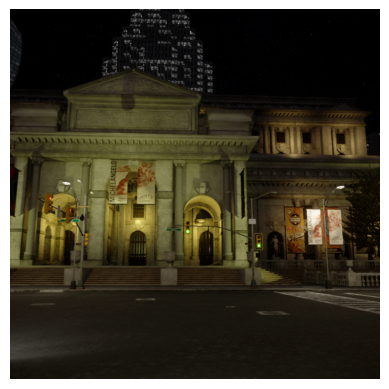

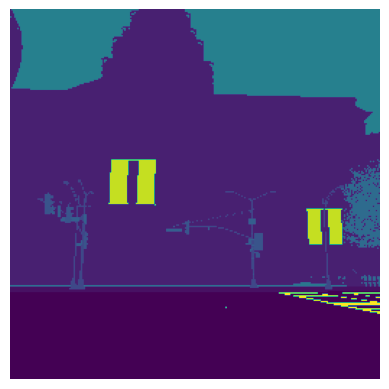

In [7]:
img = tf.io.read_file('./_out/66200.png')
img = tf.image.decode_png(img, channels=3)
img = tf.cast(img, tf.float32) / 255.0
img = img[:1000, 460:1460, :] # Crop the photo (bonnet &)

plt.imshow(img.numpy())
plt.axis('off')
plt.show()

img = tf.image.resize(img, (256, 256), method='nearest')

# Display the resized image
plt.imshow(mask.numpy())
plt.axis('off')
plt.show()
    

In [8]:
np.max(mask.numpy().flatten())

0.75

In [9]:
max_value = tf.reduce_max(mask)
print("Maximum value in the image tensor:", max_value.numpy())

Maximum value in the image tensor: 0.75


In [10]:
def loadImage(outPath, gtPath):
    
    img = tf.io.read_file(outPath)
    img = tf.image.decode_png(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = img[:1000, 460:1460, :] # Crop the photo (bonnet &)
    img = tf.image.resize(img, (256, 256), method='nearest')

    mask = tf.io.read_file(gtPath)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = mask[:1000, 460:1460, :] # Crop the bonnet
    mask = tf.image.resize(mask, (256, 256), method='nearest')
    
    return img, mask

In [11]:
def genDataset(outPath, gtPath, bufferSize, batchSize):
    
    imageList = tf.constant(outPath) 
    maskList = tf.constant(gtPath)
    dataset = tf.data.Dataset.from_tensor_slices((imageList, maskList))
    dataset = dataset.map(loadImage, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache().shuffle(bufferSize).batch(batchSize)
    
    return dataset

In [12]:

def printTrainValAccuracy(history):
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('sparse_categorical_crossentropy')
    #plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [13]:
def display(display_list):
    plt.figure(figsize=(18, 18))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [14]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = tf.expand_dims(pred_mask, axis=-1)
    return pred_mask[0]


In [15]:
def show_predictions(model, dataset, num):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [16]:
def predictDataset(dataset,model):
    preds = []
    masks = []
    for image, mask in dataset.take(len(dataset)):
        pred_mask = model.predict(image,verbose=0)
        masks.append(np.squeeze(mask[0]))
        preds.append(np.squeeze(create_mask(pred_mask)))
    flat_preds = np.concatenate(preds).flatten()
    flat_masks = np.concatenate(masks).flatten()
    return flat_preds,flat_masks


In [17]:
def predictDatasetImages(dataset,model):
    preds = []
    masks = []
    for image, mask in dataset.take(len(dataset)):
        pred_mask = model.predict(image,verbose=0)
        masks.append(np.squeeze(mask[0]))
        preds.append(np.squeeze(create_mask(pred_mask)))
    return preds,masks

In [18]:


def calculate_metrics(true_masks, predicted_masks):
    accuracy = accuracy_score(true_masks.flatten(), predicted_masks.flatten())
    precision = precision_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    f1 = f1_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    jaccard = jaccard_score(true_masks.flatten(), predicted_masks.flatten(), average='weighted', zero_division=0)
    return accuracy, precision, f1, jaccard


-------------------------------------------------------------------------------------------------
---------------------------------     Model Summary: Unet       ------------------------------
-------------------------------------------------------------------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
 

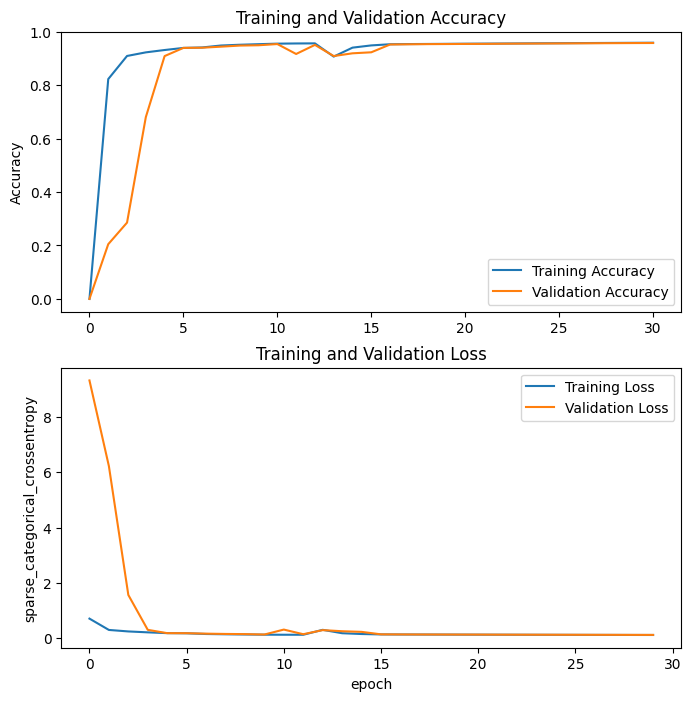

-------------------------------------------------------------------------------------------------
--------------------------------- Model performance on datasets : Unet       ------------------------------
-------------------------------------------------------------------------------------------------
63/63 [==============================] - 37s 485ms/step - loss: 0.1126 - accuracy: 0.9594
model Accuracy on the Training Dataset: 95.94%
model Accuracy on the Validation Dataset: 95.78%
model Accuracy on the Test Dataset: 95.94%
-------------------------------------------------------------------------------------------------
--------------------------------- Model evaluation : Unet       ------------------------------
-------------------------------------------------------------------------------------------------
Accuracy: 0.9583599756634424
Precision: 0.9582982913711171
F1 Score: 0.9579614687968236
Jaccard Index (IoU): 0.9229472574996876
[[ 798734    1788      11       0       0      5

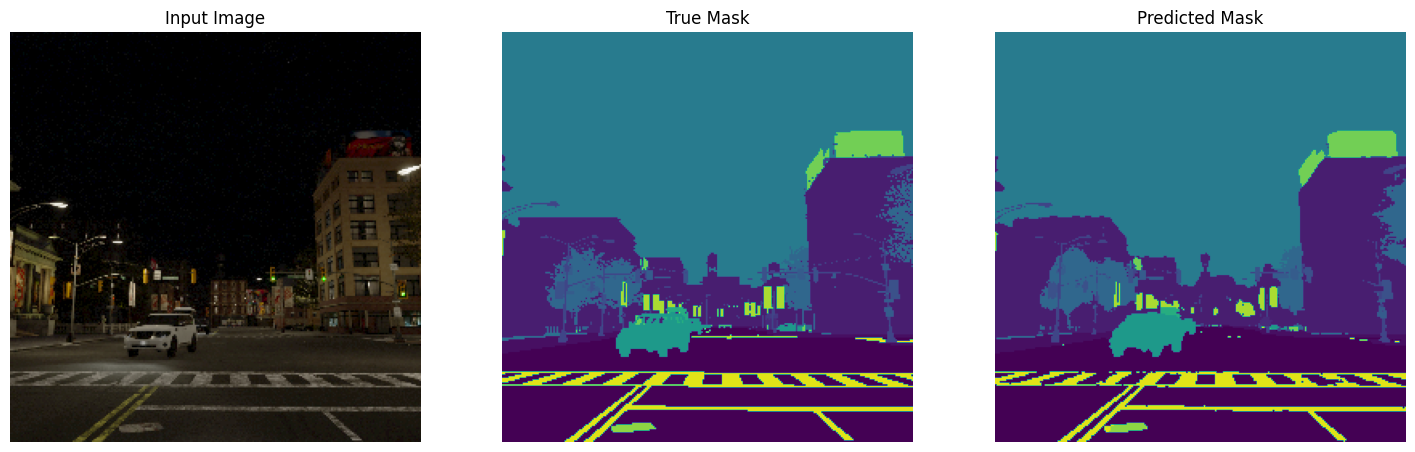

1/1 [==============================] - 0s 31ms/step


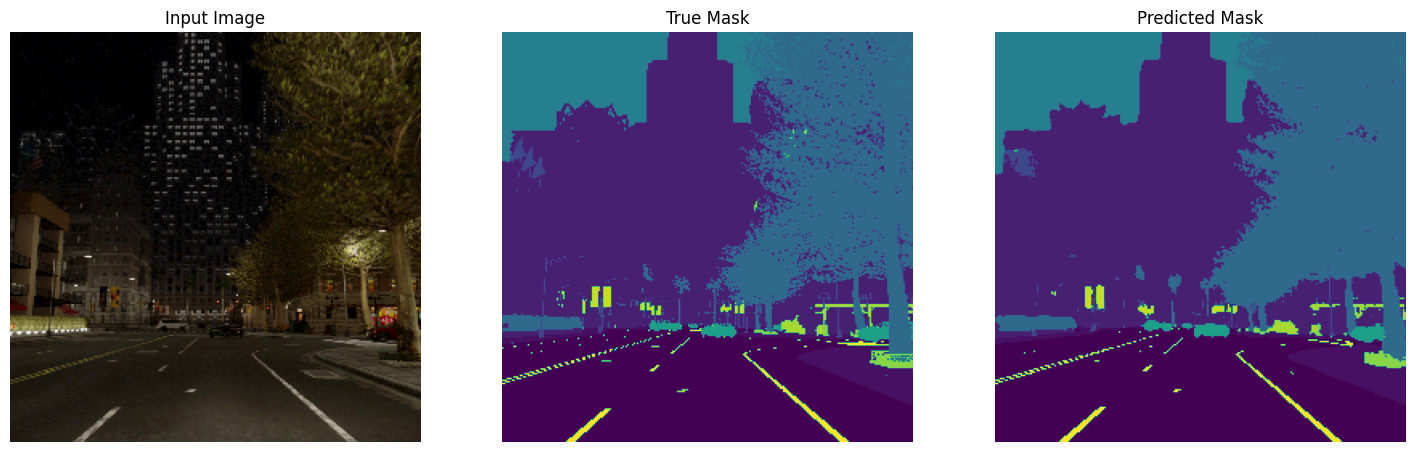

1/1 [==============================] - 0s 31ms/step


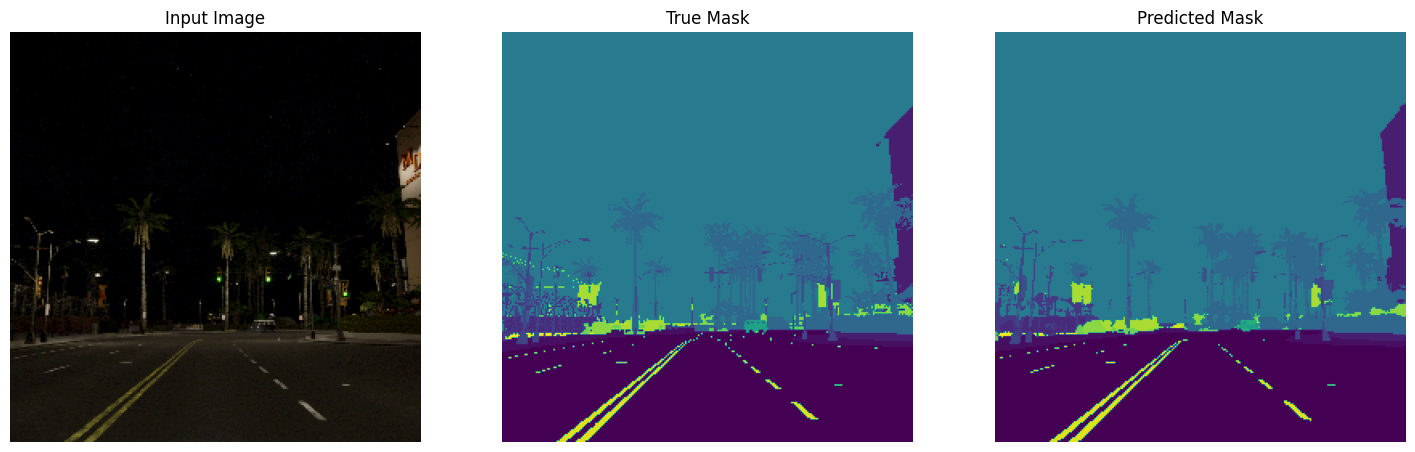

1/1 [==============================] - 0s 31ms/step


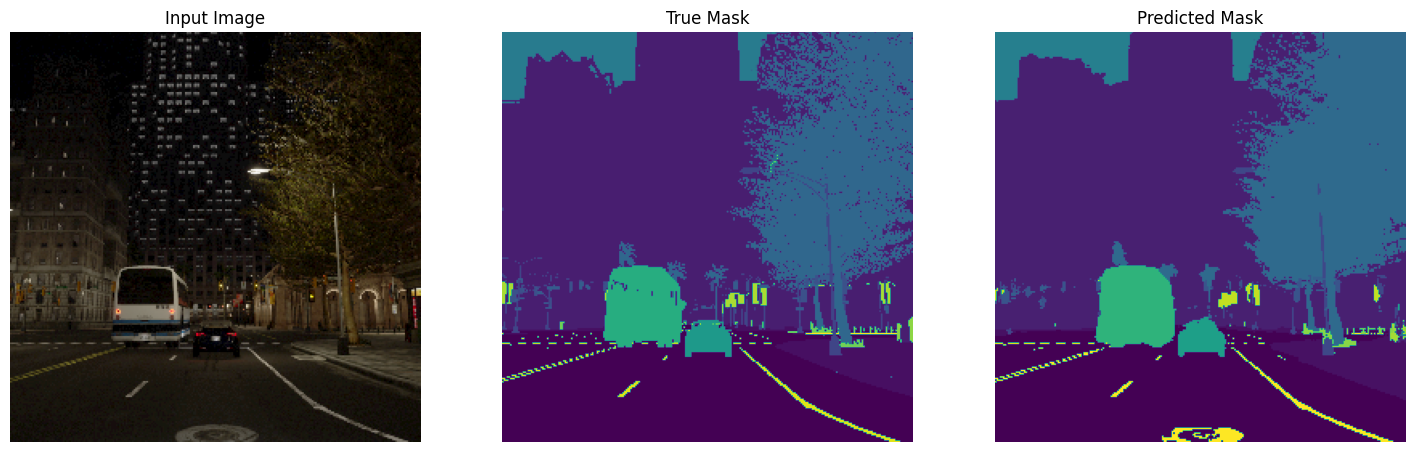

-------------------------------------------------------------------------------------------------
---------------------------------     Model Summary: DeepLab       ------------------------------
-------------------------------------------------------------------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                 

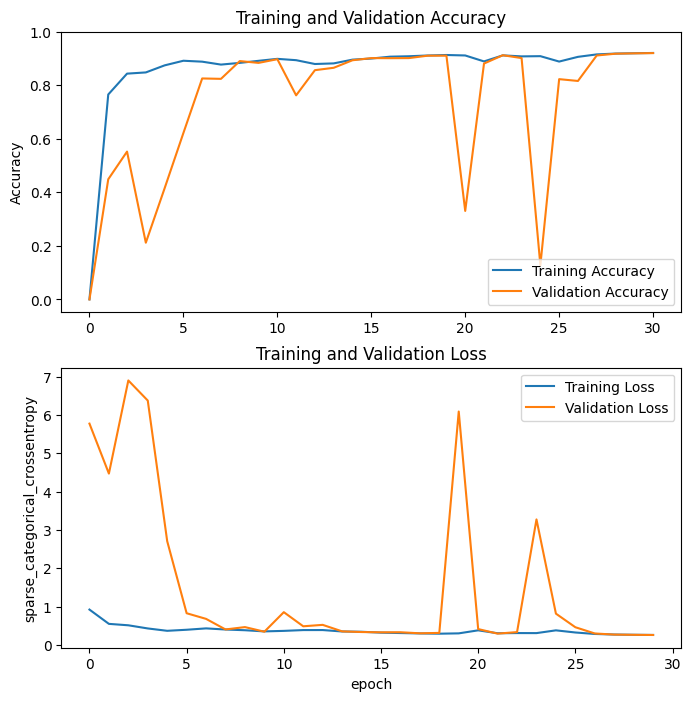

-------------------------------------------------------------------------------------------------
--------------------------------- Model performance on datasets : DeepLab       ------------------------------
-------------------------------------------------------------------------------------------------
63/63 [==============================] - 34s 433ms/step - loss: 0.2524 - accuracy: 0.9220
model Accuracy on the Training Dataset: 92.18%
model Accuracy on the Validation Dataset: 92.01%
model Accuracy on the Test Dataset: 92.2%
-------------------------------------------------------------------------------------------------
--------------------------------- Model evaluation : DeepLab       ------------------------------
-------------------------------------------------------------------------------------------------
Accuracy: 0.9173443506634424
Precision: 0.91203213087326
F1 Score: 0.9115394144603896
Jaccard Index (IoU): 0.8510893968079076
[[ 825374    6807      39       4       7    

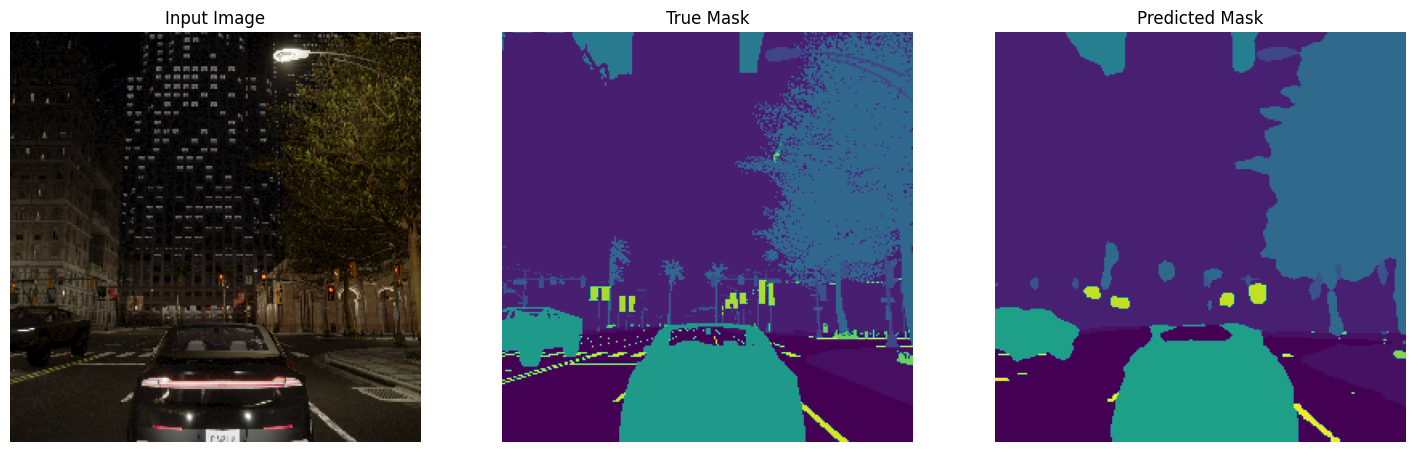

1/1 [==============================] - 0s 26ms/step


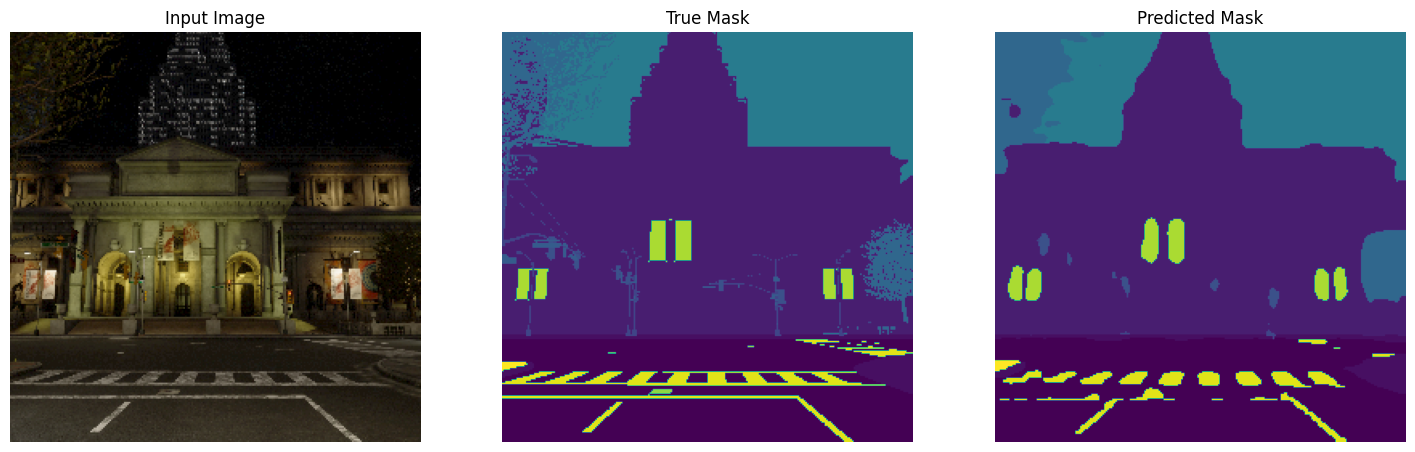

1/1 [==============================] - 0s 36ms/step


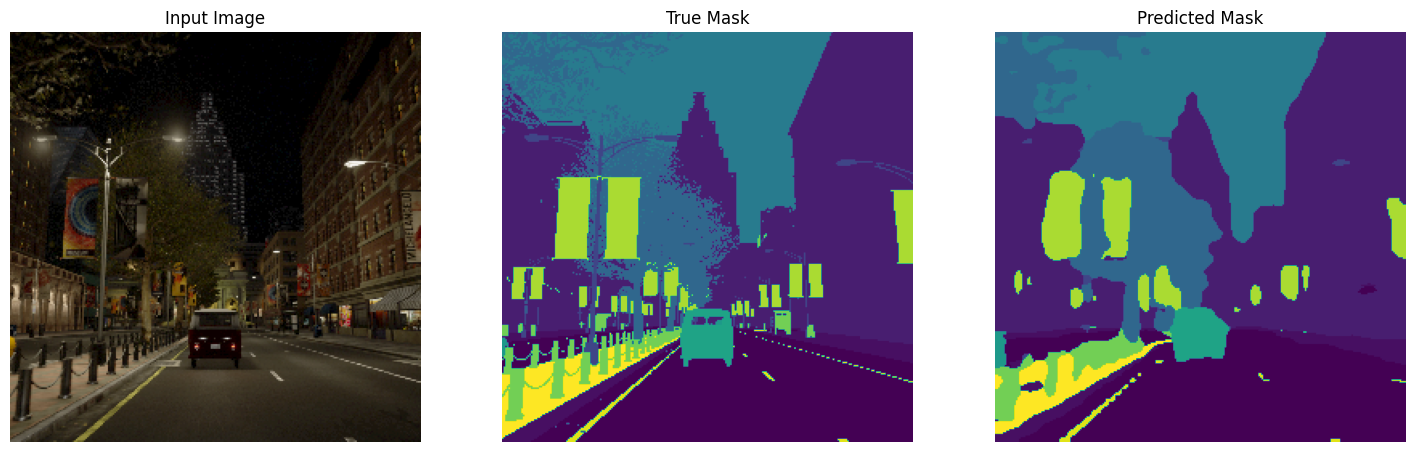

1/1 [==============================] - 0s 26ms/step


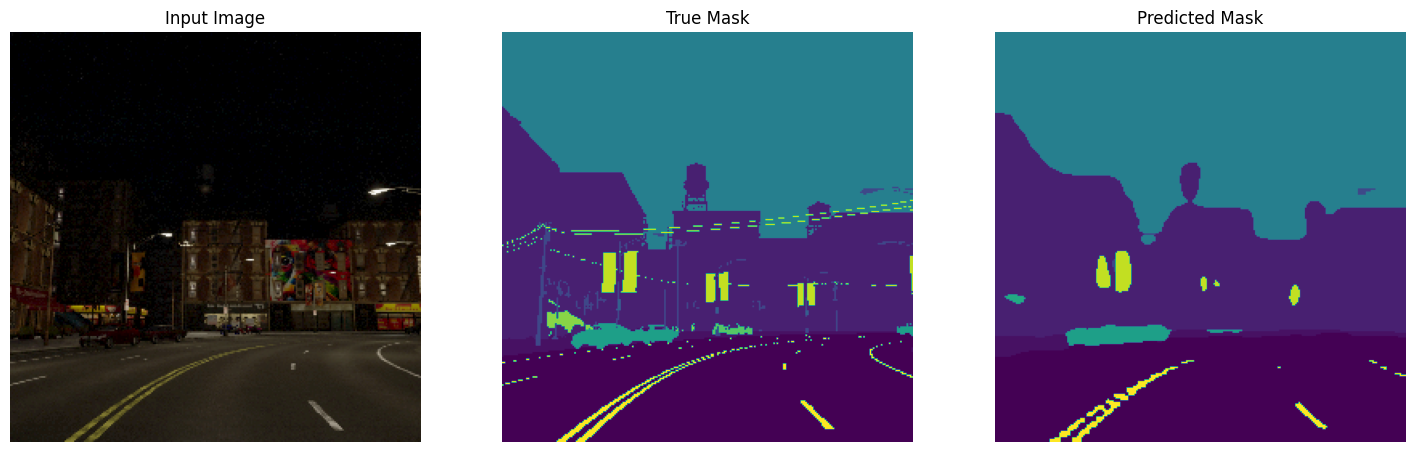

-------------------------------------------------------------------------------------------------
---------------------------------     Model Summary: Segnet       ------------------------------
-------------------------------------------------------------------------------------------------
Build enceder done..
Build decoder done..
Model: "SegNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                      

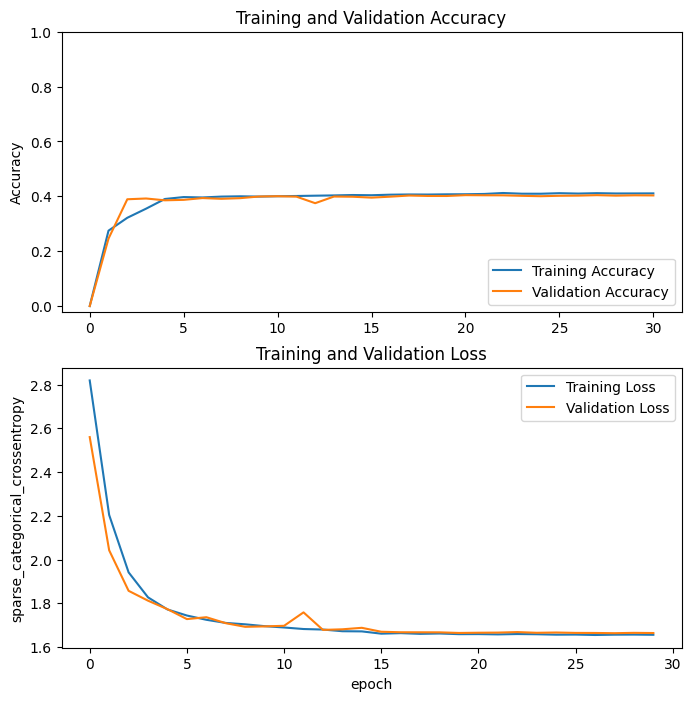

-------------------------------------------------------------------------------------------------
--------------------------------- Model performance on datasets : Segnet       ------------------------------
-------------------------------------------------------------------------------------------------
200/200 [==============================] - 36s 152ms/step - loss: 1.6768 - accuracy: 0.4024
model Accuracy on the Training Dataset: 40.33%
model Accuracy on the Validation Dataset: 40.3%
model Accuracy on the Test Dataset: 40.24%
-------------------------------------------------------------------------------------------------
--------------------------------- Model evaluation : Segnet       ------------------------------
-------------------------------------------------------------------------------------------------
Accuracy: 0.8688033294677734
Precision: 0.8642135946510185
F1 Score: 0.8526121353174709
Jaccard Index (IoU): 0.7702861543391493
[[2542563   24876    2013       0       0  

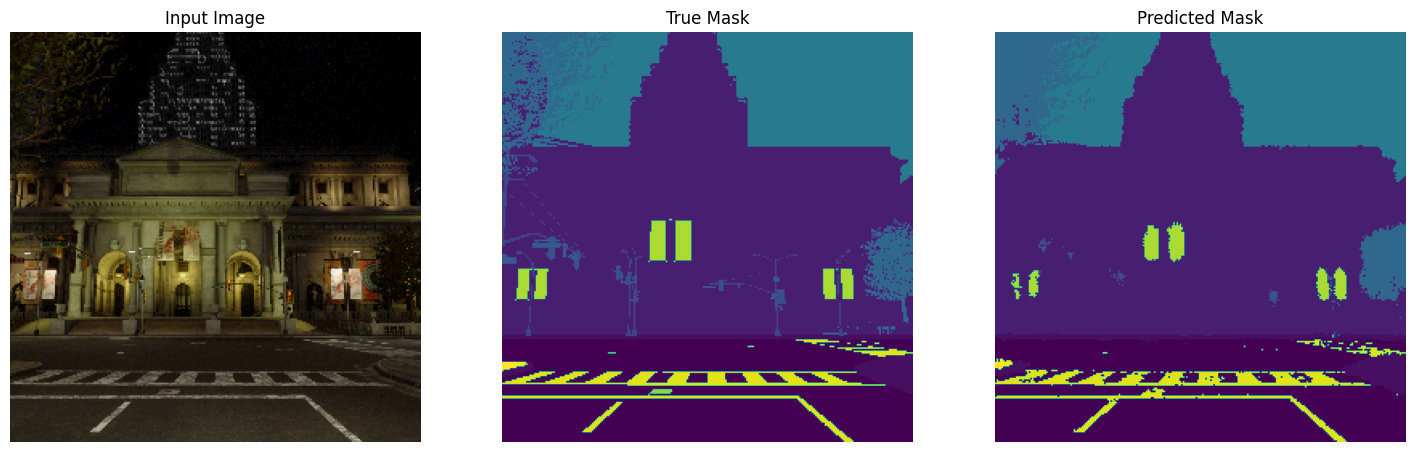

1/1 [==============================] - 0s 104ms/step


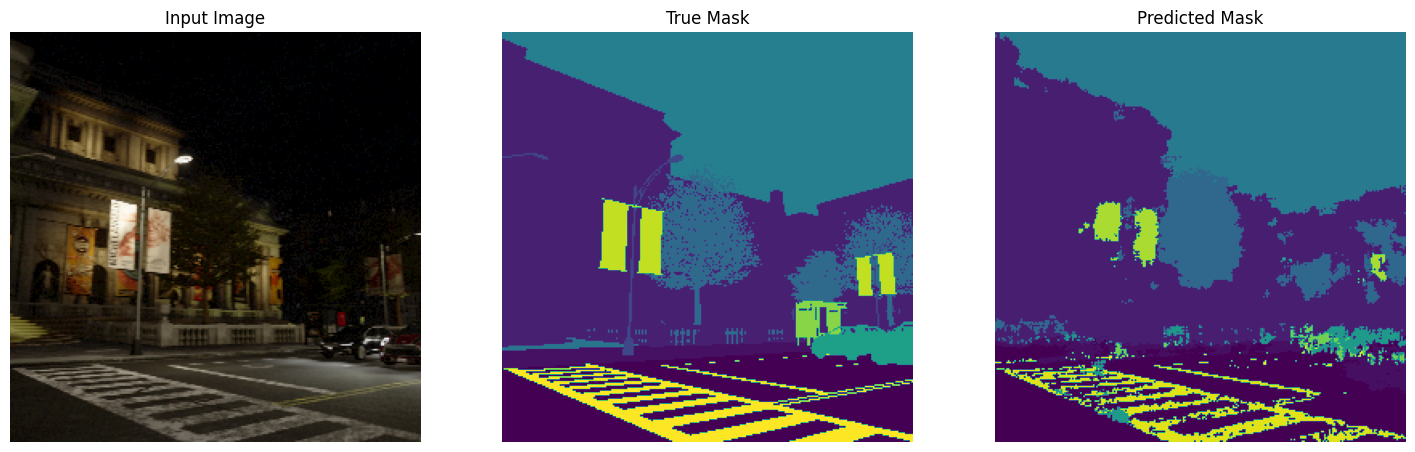

1/1 [==============================] - 0s 113ms/step


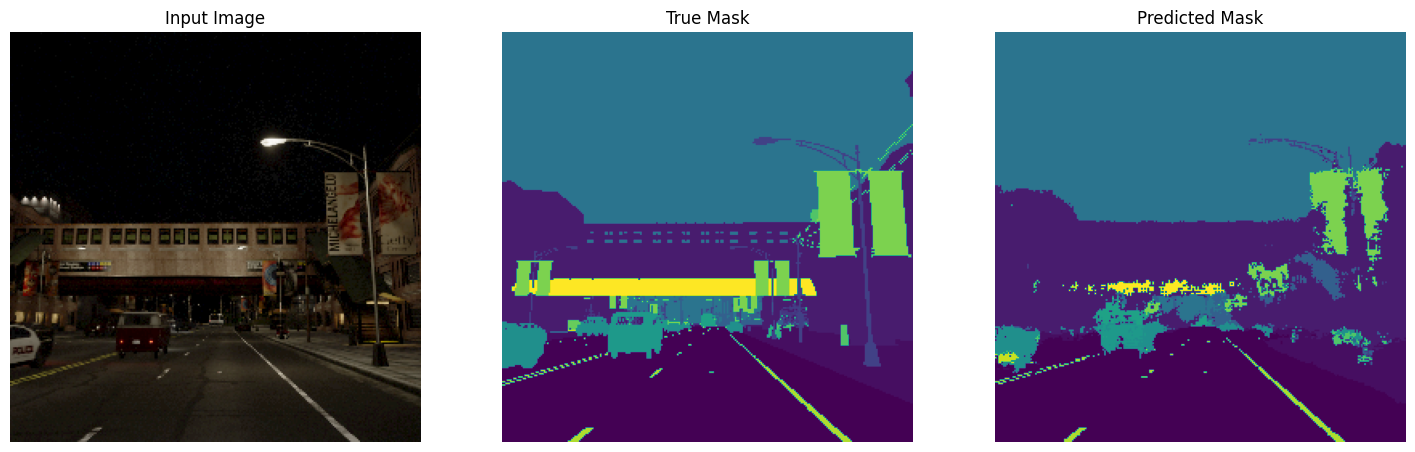

1/1 [==============================] - 0s 104ms/step


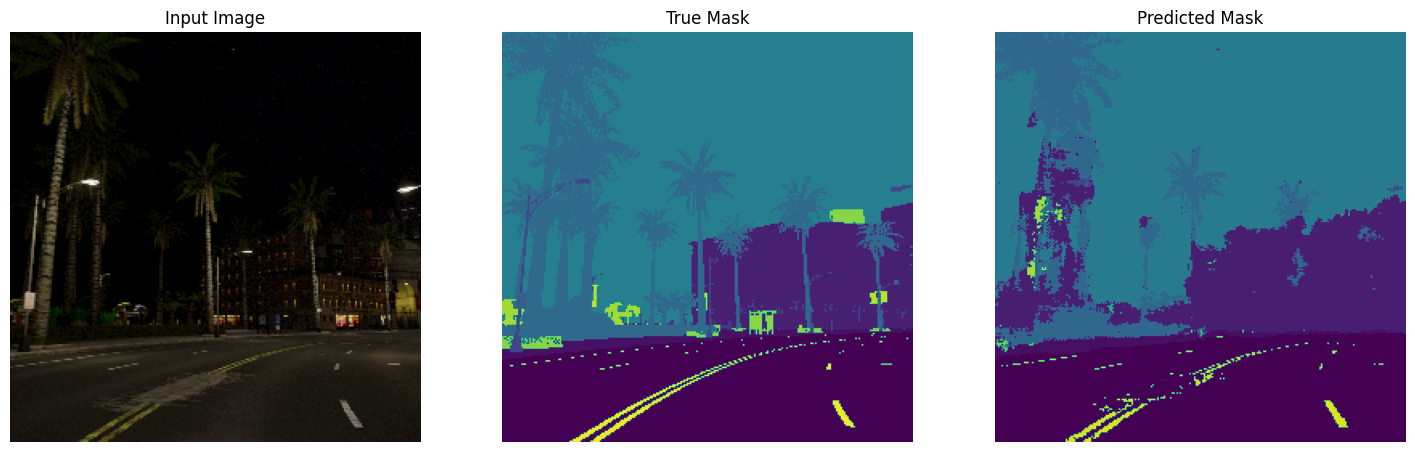

-------------------------------------------------------------------------------------------------
---------------------------------     Model Summary: PspNet       ------------------------------
-------------------------------------------------------------------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block_1_a (Conv2D)             (None, 256, 256, 32  128         ['input_1[0][0]']                
                                )                                                                 

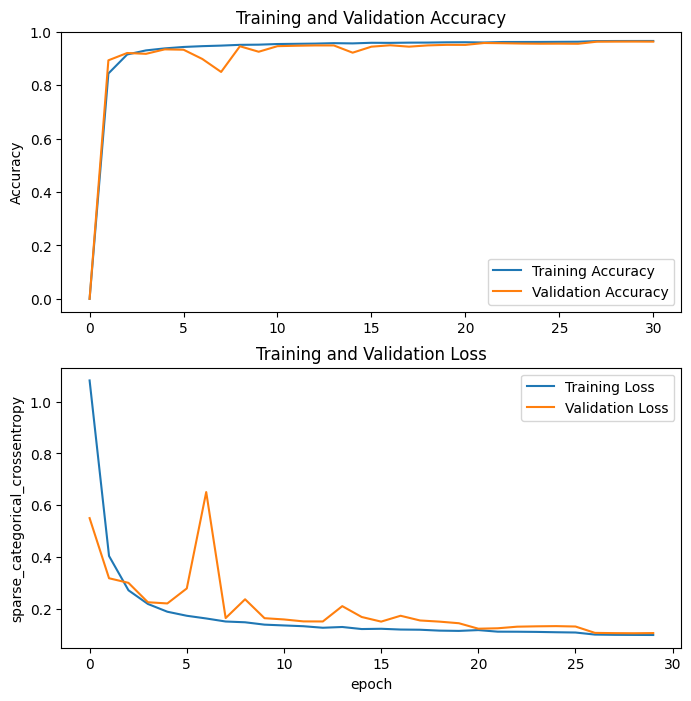

-------------------------------------------------------------------------------------------------
--------------------------------- Model performance on datasets : PspNet       ------------------------------
-------------------------------------------------------------------------------------------------
400/400 [==============================] - 91s 212ms/step - loss: 0.1015 - accuracy: 0.9649
model Accuracy on the Training Dataset: 96.52%
model Accuracy on the Validation Dataset: 96.28%
model Accuracy on the Test Dataset: 96.49%
-------------------------------------------------------------------------------------------------
--------------------------------- Model evaluation : PspNet       ------------------------------
-------------------------------------------------------------------------------------------------
Accuracy: 0.9651437759399414
Precision: 0.9652487989919071
F1 Score: 0.9650434587665992
Jaccard Index (IoU): 0.9344627227205167
[[      0       0       0       0       0 

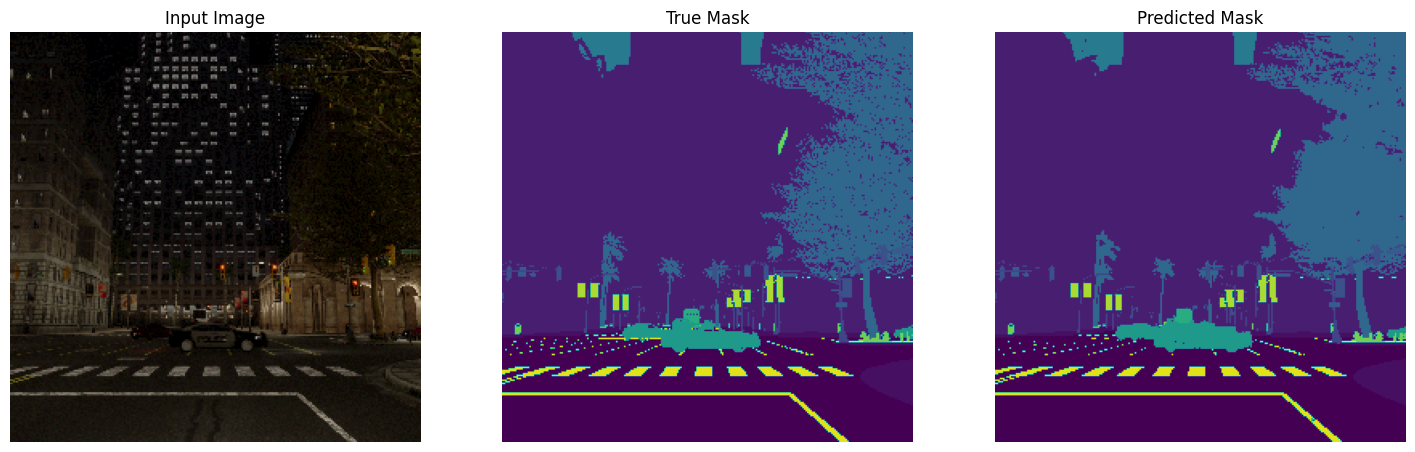

1/1 [==============================] - 0s 31ms/step


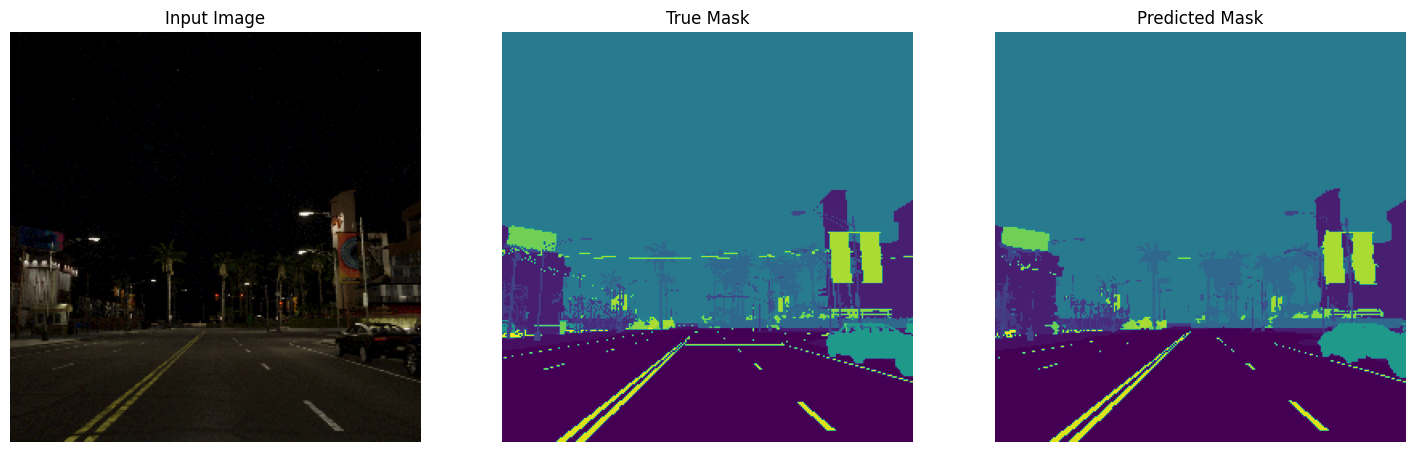

1/1 [==============================] - 0s 16ms/step


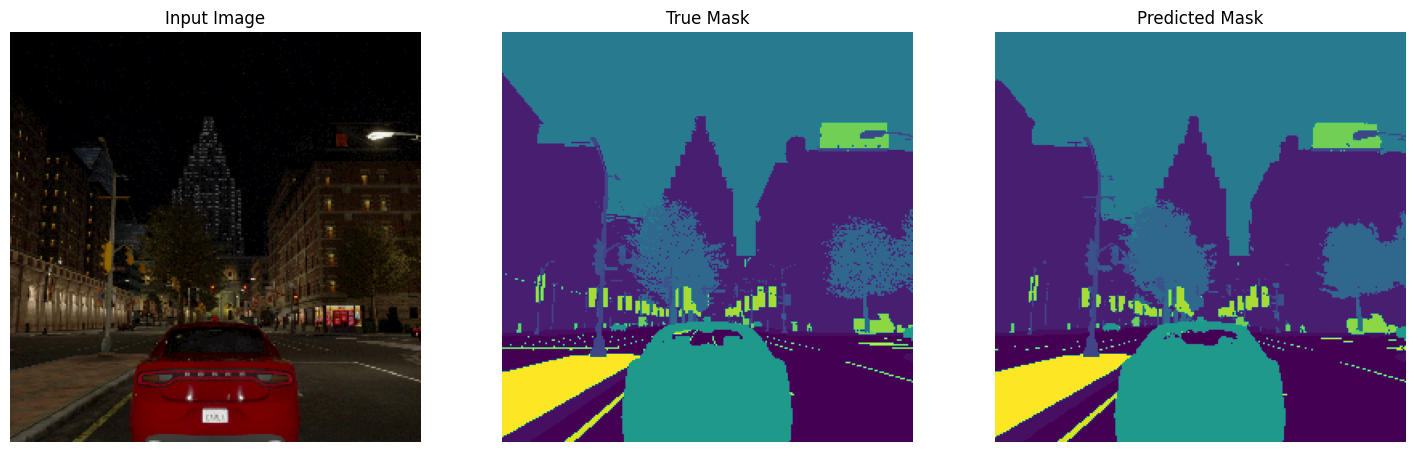

1/1 [==============================] - 0s 31ms/step


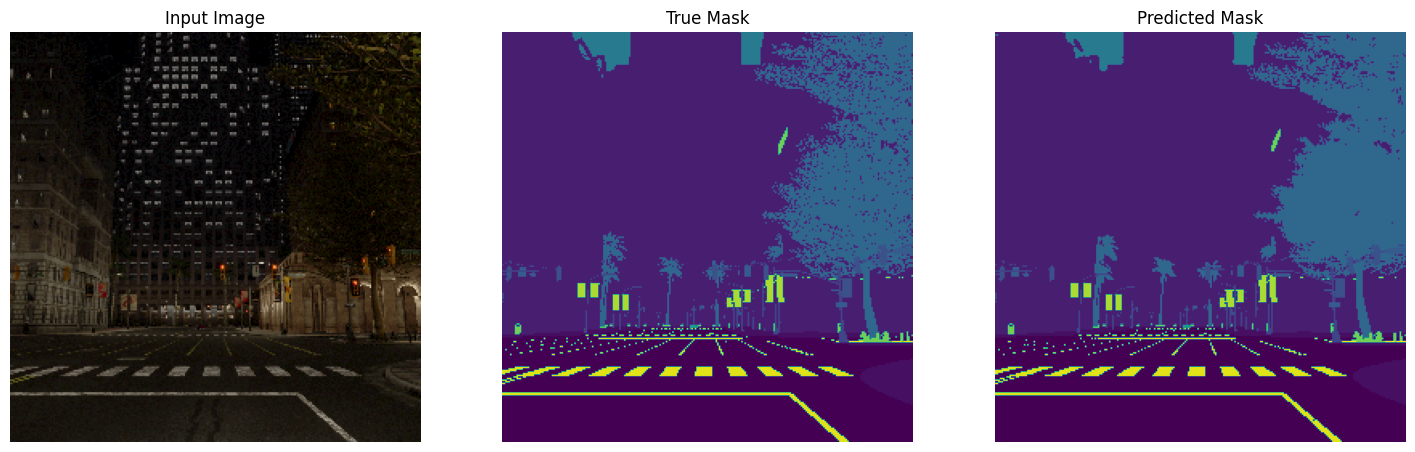

In [19]:
imgShape = (256,256,3)

filters = 32
labels = 32 # True/False 32 total classes if you want to go for full class classification 
model_metrics = {}

for modelChoice in modelList:
    print('-------------------------------------------------------------------------------------------------')
    print('---------------------------------     Model Summary: '+ modelChoice +'       ------------------------------')
    print('-------------------------------------------------------------------------------------------------')
    
    if(modelChoice == 'Unet'):
        batchSize = 32
        bufferSize = 500
        model = Models.Unet.unet(imgShape, labels,filters )
        model.summary()
    elif(modelChoice == 'Segnet'):
        batchSize = 10 #Lower batchSize to fit into GPU mem
        bufferSize = 500
        filters = 32
        model = Models.Segnet.segnet(imgShape, labels, 3, (2, 2), "softmax")
    # encoder
        model.summary()
    elif(modelChoice == 'DeepLab'):
        batchSize = 32
        bufferSize = 500
        filters = 32
        model = Models.DeepLab.DeepLab(imgShape, labels)
        model.summary()
    elif(modelChoice == 'PspNet'):
        batchSize = 5 #Lower batchSize to fit into GPU mem
        bufferSize = 500
        filters = 32
        model = Models.PspNet.pspNet(imgShape, labels)
        model.summary()
    else:
        print('Model choice not in list')


    #Create Datasets with batchSize
    trainDataset = genDataset(X_train, y_train, bufferSize, batchSize)
    valDataset = genDataset(X_val, y_val, bufferSize, batchSize)
    testDataset = genDataset(X_test, y_test, bufferSize, batchSize)

    #Compile Model
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    ES = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1)
    reduceLR = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=5, verbose=1, min_lr = 2e-6)

    print('-------------------------------------------------------------------------------------------------')
    print('---------------------------------     Training: '+ modelChoice +'       ------------------------------')
    print('-------------------------------------------------------------------------------------------------')
    
    
    epochs = 30

    #Training the models (With Emissions measurement)
    MeasureEmissions = False
    if(MeasureEmissions == True):
        from codecarbon import EmissionsTracker
        tracker = EmissionsTracker(log_level='error')
        tracker.start()
    try:
        start_time = time.time() #Timer for training time 
        history = model.fit(trainDataset, 
                            validation_data = valDataset, 
                            epochs = epochs, 
                            verbose=1, 
                            callbacks = [ES, reduceLR], 
                            batch_size = batchSize, 
                            shuffle = True)
    finally:
        if(MeasureEmissions == True):
            tracker.stop()
            
    
    end_time = time.time() #taining time calculation
    training_time = end_time - start_time
    print(f"Training time: {training_time} seconds")

    print('-------------------------------------------------------------------------------------------------')
    print('---------------------------------     Model History: '+ modelChoice +'       ------------------------------')
    print('-------------------------------------------------------------------------------------------------')
    

    printTrainValAccuracy(history)

    

    #Saving the model
    
    if 'model' not in globals():
        model = tf.keras.models.load_model('./Models/'+modelChoice + '.h5')
    
    else:
        model.save('./Models/'+modelChoice + '.h5')


    print('-------------------------------------------------------------------------------------------------')
    print('--------------------------------- Model performance on datasets : '+ modelChoice +'       ------------------------------')
    print('-------------------------------------------------------------------------------------------------')
    
    
    
    #Measure train test val accuracy & loss
    train_loss, train_accuracy = model.evaluate(trainDataset, batch_size = 32)
    validation_loss, validation_accuracy = model.evaluate(valDataset, batch_size = 32)
    test_loss, test_accuracy = model.evaluate(testDataset, batch_size = 32)
    
    print(f'model Accuracy on the Training Dataset: {round(train_accuracy * 100, 2)}%')
    print(f'model Accuracy on the Validation Dataset: {round(validation_accuracy * 100, 2)}%')
    print(f'model Accuracy on the Test Dataset: {round(test_accuracy * 100, 2)}%')



    print('-------------------------------------------------------------------------------------------------')
    print('--------------------------------- Model evaluation : '+ modelChoice +'       ------------------------------')
    print('-------------------------------------------------------------------------------------------------')
    
    
    
    # Calculate evaluation metrics
    
    flat_preds, flat_masks = predictDataset(testDataset, model)
    accuracy, precision, f1, jaccard = calculate_metrics(flat_masks, flat_preds)

    class_list = np.unique(flat_preds).tolist()
    confusion_m = confusion_matrix(flat_masks, flat_preds,labels=class_list)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')
    print(f'Jaccard Index (IoU): {jaccard}')
    print(confusion_m)

    if MeasureEmissions:
        co2_emissions = tracker.co2e
    
        model_metrics[modelChoice] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'F1 Score': f1,
            'Jaccard Index (IoU)': jaccard,
            'Confusion Matrix': confusion_m.tolist(),  # Convert to list for better readability,
            'Training Time': training_time,
            'CO2E':co2_emissions
        }
    else:
        model_metrics[modelChoice] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'F1 Score': f1,
            'Jaccard Index (IoU)': jaccard,
            'Confusion Matrix': confusion_m.tolist(),  # Convert to list for better readability,
            'Training Time': training_time
        }
        

    show_predictions(model, testDataset,4)
    tf.keras.backend.clear_session()



    

In [20]:

# Create a DataFrame from the collected metrics dictionary
df = pd.DataFrame(model_metrics)

# Transpose the DataFrame for better readability
df = df.transpose()

# Display the DataFrame
print(df)

         Accuracy Precision  F1 Score Jaccard Index (IoU)  \
Unet      0.95836  0.958298  0.957961            0.922947   
DeepLab  0.917344  0.912032  0.911539            0.851089   
Segnet   0.868803  0.864214  0.852612            0.770286   
PspNet   0.965144  0.965249  0.965043            0.934463   

                                          Confusion Matrix Training Time  
Unet     [[798734, 1788, 11, 0, 0, 54, 0, 0, 13, 0, 0, ...   4848.356998  
DeepLab  [[825374, 6807, 39, 4, 7, 0, 33, 0, 3152, 605,...   3922.412465  
Segnet   [[2542563, 24876, 2013, 0, 0, 198, 0, 0, 259, ...   6808.288408  
PspNet   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  22143.376786  


In [21]:
df.to_excel('results.xlsx', index=True)